# Obtain and decompress data

Note: Uncomment this section if the data has not been download and extracted. 

In [1]:
# #Download the dataset from opensig
# import urllib.request
# urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')

In [2]:
# #decompress the .bz2 file into .tar file
# import sys
# import os
# import bz2

# zipfile = bz2.BZ2File('./RML2016.10a.tar.bz2') # open the file
# data = zipfile.read() # get the decompressed data

In [3]:
# #write the .tar file
# open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

In [4]:
# #extract the .tar file
# import tarfile
# my_tar = tarfile.open('./RML2016.10a.tar')
# my_tar.extractall('./') # specify which folder to extract to
# my_tar.close()

In [5]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
Xin = []  
lbl = []
for mod in mods:
    for snr in snrs:
        Xin.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
Xin = np.vstack(Xin)
print(mods)

[b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']


# Import libraries

In [6]:
# Import all libraries used for this NN development
%matplotlib inline
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
import numpy as np
import pandas as pd
from sklearn import preprocessing as preprocess
from scipy.signal import hilbert
import time

# Feature Extraction

In [7]:
#Helper Functions

#Get instantaneous cener frequencies from phase.
def instFreq(a): 
    #https://en.wikipedia.org/wiki/Instantaneous_phase_and_frequency
    a_phi_unwrapped = np.subtract(np.unwrap(np.arctan2(Xin[:,1], Xin[:,0])), 2*np.pi*Ts)#1e6*N)
    f = np.zeros([a.shape[0], a.shape[1]-1])
    for i in range(0,f.shape[1]):
        f[:,i] =  np.angle(np.multiply(a[:,i+1], np.conjugate(a[:,i])))
    return f

#Get Statistical Moment
def getMoment(a, x, y):
    xy = x - y
    return (np.mean(np.multiply(a**xy, np.conjugate(a)**y), axis = 1))
    

In [23]:
t_0=time.time() #Start timer to time feature extraction

### ----- Pre-Calculate Signal Properties for Feature Extraction ----- ###

#pre-calculate the phase, magnitude, and mean for feature calculations
Ts = np.linspace(0, 127e-6, 128)           #sample times (128 samples at 1MHz Sample Rate)
a = np.add(Xin[:,0], 1j*Xin[:,1])          #Convert data array to Nx128 numpy complex number matrix

#Number of samples per signal 
N = a.shape[1]  

#Instantaneous phase
a_phi = np.subtract(np.angle(a), 2*np.pi*Ts)

#Scale the input amplitude to make the maximum in-phase OR quadrature value 1. (Add Signal Gain Automatically)
scale = np.max([np.max(np.abs(np.real(a))), np.max(np.abs(np.imag(a)))])
a = a/scale

#Instantaneous signal magnitide
a_mag = np.abs(a) 

#Average signal magnitude
a_mean = np.mean(np.abs(a), axis=1)

#normalized instantaneous magnitude
a_n = np.abs(a_mag.T / np.mean(a_mag, axis=1)).T

#normalized centered instantaneous amplitude
a_cn = np.subtract(a_n , 1)

#normalized signal amplitude
a_v = np.subtract(np.sqrt(np.abs(a.T / np.var(a, axis=1)).T), 1)

#outlier detectction threshold
a_t = 1                                    
a_phi_t = np.multiply(a_phi, 1*(np.abs(a_n) > a_t))  #thresholded a_phi to 0 where a_mag < a_t
c = np.sum((np.abs(a_n) > a_t), axis=1)              #of remaining values in each sample

#instantanous frequency
fn = instFreq(a)      

#normalized instantanous freuency (peak = 1)
fn_n = np.divide(fn.T, np.max(fn, axis = 1)).T 

#FFT spectrum of the normalized centered instantaneous amplitude
freq = np.fft.fft(a_cn, axis=1)/1000000

#Get moments for cumulants
M_20 = getMoment(a, 2, 0)
M_21 = getMoment(a, 2, 1)
M_22 = getMoment(a, 2, 2)
M_40 = getMoment(a, 4, 0)
M_41 = getMoment(a, 4, 1)
M_42 = getMoment(a, 4, 2)
M_60 = getMoment(a, 6, 0)
M_61 = getMoment(a, 6, 1)
M_62 = getMoment(a, 6, 2)
M_63 = getMoment(a, 6, 3)
M_80 = getMoment(a, 8, 0)


### ----- Perform Feature Extractions ----- ###

#1. ratio of in-phase and quadrature component signal power
beta = np.divide(np.sum(np.real(a)**2, axis = 1), np.sum(np.imag(a)**2, axis = 1))/10
# print(beta.shape)
# print(beta)
   
#2. Standard deviation of the direct instantaeous phase
# s_dp = (1/X_train.shape[2]*np.sum(np.power(phi,2), axis = 1) - 1/X_train.shape[2]*np.power(np.sum(phi, axis = 1),2))
s_dp = np.sqrt(np.divide(np.sum(a_phi_t**2, axis = 1), c) - (np.divide(np.sum(a_phi_t, axis=1), c))**2)

#3. Standard deviation of the absolute value of the non-linear component of the absolute phase
s_ap = np.sqrt(np.divide(np.sum(a_phi_t**2, axis = 1), c) - (np.divide(np.sum(np.abs(a_phi_t), axis=1), c))**2)

#4. Standard deviation of the absolute value of the normalized instantaneous amplitude of the simulated signal
s_aa = np.sqrt(np.divide(np.sum(a_cn**2, axis = 1), N) - (np.divide(np.sum(np.abs(a_cn), axis=1), N))**2)

#5. Standard deviation of the absolute value of the normalized centered instantaneous frequency for the signal segment
s_af = np.sqrt( np.divide(np.sum(fn**2, axis=1),fn.shape[1]) + (np.divide(np.sum(np.abs(fn), axis=1),fn.shape[1]))**2)

#6. Standard deviation of the absolute value of the normalized centered sigbal amplitude for the signal segment
s_v = np.sqrt( np.divide(np.sum(a_v**2, axis=1),N) + np.divide((np.sum(np.abs(a_v), axis=1))**2,N) )/100

#7. Mixed order moments v_20
v_20 = np.divide(np.mean(a_mag**4, axis=1), np.mean(a_mag**2, axis=1))*100

#8. Maximum value of power spectral density (PSD) of the normalized signal samples
Pmax = np.divide(np.max(np.abs((freq))**2, axis=1), N)

#9. Cumulant C20
C_20 = M_20
C_20 = np.abs(C_20)*1e3

#10. Cumulant C21
C_21 = M_21
C_21 = np.abs(C_21)*1e3

#11. Cumulant C40
C_40 = M_40 - np.multiply(M_20**2,3)
C_40 = np.abs(C_40)*1e5

#12. Cumulant C41
C_41 = M_41 - np.multiply(np.multiply(M_20, M_21),3)
C_41 = np.abs(C_41)*1e5

#13. Cumulant C42
C_42 = M_42 - np.abs(M_20)**2 - np.multiply(M_21**2, 2)
C_42 = np.abs(C_42)*1e5

#14. Cumulant C60
C_60 = M_60 - np.multiply(np.multiply(M_20, M_40), 15) + np.multiply(M_20**2, 3)
C_60 = np.abs(C_60)*1e5

#15. Cumulant C61
C_61 = M_61 - np.multiply(np.multiply(M_21, M_41), 10) \
    - np.multiply(np.multiply(M_21, M_40), 5) \
    + np.multiply(np.multiply(M_21, M_20**2), 30)
C_61 = np.abs(C_61)*1e5

#16. Cumulant C61
C_62 = M_62 - np.multiply(np.multiply(M_20, M_42), 6) \
    - np.multiply(np.multiply(M_21, M_41), 8) \
    - np.multiply(M_22, M_40) \
    + np.multiply(np.multiply(M_20**2, M_22), 6) \
    + np.multiply(np.multiply(M_21**2, M_20),24) 
C_62 = np.abs(C_62)*1e6

#17. Cumulant C63
C_63 = M_63 - np.multiply(np.multiply(M_20, M_42), 3) \
    - np.multiply(np.multiply(M_42, M_21), 9) \
    - np.multiply(np.multiply(M_22**2, M_41), 3) \
    + np.multiply(np.multiply(np.multiply(M_20, M_21), M_22), 18) \
    + np.multiply(M_21**3, 12) 
C_63 = np.abs(C_63)*1e5


#18. Cumulant C80
C_80 = M_80 - np.multiply(M_40**2, 35) \
    - np.multiply(np.multiply(M_60, M_20), 28) \
    + np.multiply(M_40, 420) - np.multiply(M_20**4, 630)
C_80 = np.abs(C_80)*1e3

#19. Kurtosis
fn_mean = np.mean(fn_n, axis = 1)
K = np.abs(np.divide(np.mean((np.subtract(a.T,a_mean).T)**4, axis=1),np.mean((np.subtract(a.T,a_mean).T)**2, axis=1)**2))/1000

#20. Kurtosis
Kf = np.abs(np.divide(np.mean((np.subtract(fn_n.T,a_mean).T)**4, axis=1),np.mean((np.subtract(fn_n.T,a_mean).T)**2, axis=1)**2))/10

#21. Skewnwess ####Should use a_mag
S = np.abs(np.divide(np.mean((np.subtract(a_mag.T,a_mean).T)**3, axis=1),np.mean((np.subtract(a_mag.T,a_mean).T)**2, axis=1)**(3/2)))/10

#22. Peak-to-RMS Ratio
PR = np.divide(np.max(a_mag**2, axis=1),np.divide(np.sum(a_mag, axis=1)**2,N))*10

#23. Peak-to-Average Ratio
PA = np.divide(np.max(a_mag, axis=1),np.divide(np.sum(a_mag, axis=1),N))/2


#Calculate and print time to perform feature extraction
delta_t=time.time()-t_0
print(delta_t)    



#Build and normalize the feature matrix
features = np.vstack(( \
    beta, s_dp, s_ap, s_aa, s_af, s_v, v_20, Pmax, \
    C_20, C_21, C_40, C_41, C_42, C_60, C_61, C_62,  \
    C_63, C_80, K, Kf, S, PR, PA)).T
features = preprocess.scale(features, axis = 1)

203.55881690979004


### Partition and Format Input Data and Labels

In [9]:
# Partition the data
#  into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = features.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = features[train_idx]
X_test =  features[test_idx]

In [10]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]
y_test=lbl_encoded[test_idx]

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 23) [23]


## Build Deep Neural Network

In [12]:
#Extracted Feature Deep Neural Network
# - Three hidden layers with 256, 128, and 64 neurons per layer. Outuput layer is 11 neurons. 
model = models.Sequential() #Keras Model
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Dense(256, kernel_initializer='RandomNormal', activation='relu', name="dense1"))
model.add(Dense(128, kernel_initializer='RandomNormal', activation='relu', name="dense2"))
model.add(Dense(64, kernel_initializer='RandomNormal', activation='relu', name="dense3"))
model.add(Dense( len(classes), kernel_initializer='RandomNormal', activation = 'softmax', name="out"))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 23)             0         
_________________________________________________________________
dense1 (Dense)               (None, 1, 256)            6144      
_________________________________________________________________
dense2 (Dense)               (None, 1, 64)             16448     
_________________________________________________________________
dense3 (Dense)               (None, 1, 64)             4160      
_________________________________________________________________
out (Dense)                  (None, 1, 11)             715       
_________________________________________________________________
reshape_1 (Reshape)          (None, 11)                0         
Total params: 27,467
Trainable params: 27,467
Non-trainable params: 0
____________________________________________________

In [13]:
# Set up some params 
nb_epoch = 1000   # number of epochs to train on
batch_size = 100  # training batch size

# Train Neural Network

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [15]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'DNN.wts.h5'
import time
t_0=time.time()

history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 88000 samples, validate on 22000 samples
Epoch 1/1000
88000/88000 - 6s - loss: 1.5480 - accuracy: 0.4173 - val_loss: 1.3972 - val_accuracy: 0.4846
Epoch 2/1000
88000/88000 - 5s - loss: 1.3527 - accuracy: 0.4944 - val_loss: 1.3291 - val_accuracy: 0.4877
Epoch 3/1000
88000/88000 - 5s - loss: 1.3241 - accuracy: 0.5019 - val_loss: 1.3364 - val_accuracy: 0.4955
Epoch 4/1000
88000/88000 - 5s - loss: 1.3121 - accuracy: 0.5063 - val_loss: 1.3060 - val_accuracy: 0.5062
Epoch 5/1000
88000/88000 - 5s - loss: 1.3062 - accuracy: 0.5091 - val_loss: 1.2939 - val_accuracy: 0.5106
Epoch 6/1000
88000/88000 - 5s - loss: 1.3008 - accuracy: 0.5106 - val_loss: 1.2988 - val_accuracy: 0.5095
Epoch 7/1000
88000/88000 - 5s - loss: 1.2978 - accuracy: 0.5125 - val_loss: 1.2996 - val_accuracy: 0.5073
Epoch 8/1000
88000/88000 - 5s - loss: 1.2931 - accuracy: 0.5132 - val_loss: 1.2933 - val_accuracy: 0.5090
Epoch 9/1000
88000/88000 - 5s - loss: 1.2910 - accuracy: 0.5140 - val_loss: 1.2863 - val_accuracy: 0.5

# Evaluate and Plot Model Performance

In [16]:
# Show and time simple version of performance

t_0=time.time()
score = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score)
delta_t=time.time()-t_0
print(delta_t)

[1.2654503844160552, 0.5237273]
2.0257771015167236


Text(0, 0.5, 'Cross-Entropy Loss')

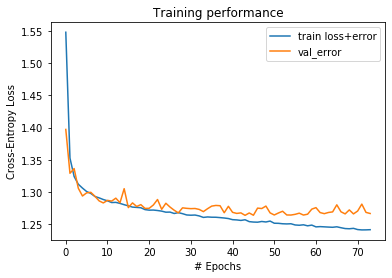

In [17]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()
plt.xlabel('# Epochs')
plt.ylabel('Cross-Entropy Loss')

In [18]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []

snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])

#print(snr_label_array)
y_test_snr=snr_array[test_idx]

#Obtain and print accuracy for each SNR. Categorize the acccuracy for each label and SNR
acc_label_snr = np.ones(len(classes))
for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))
    
    acc_label_snr  = np.vstack((acc_label_snr , np.divide(np.diag(conf),np.sum(conf, axis=0))))
acc_label_snr = np.delete(acc_label_snr, 0, 0)



Overall Accuracy:  0.09375 for SNR b'-20'
Overall Accuracy:  0.09600292024091987 for SNR b'-18'
Overall Accuracy:  0.09628561125135232 for SNR b'-16'
Overall Accuracy:  0.0993050475493782 for SNR b'-14'
Overall Accuracy:  0.12529043789097408 for SNR b'-12'
Overall Accuracy:  0.1769358101894427 for SNR b'-10'
Overall Accuracy:  0.2805103550295858 for SNR b'-8'
Overall Accuracy:  0.3769413484377855 for SNR b'-6'
Overall Accuracy:  0.4603800645392614 for SNR b'-4'
Overall Accuracy:  0.5415758896151053 for SNR b'-2'
Overall Accuracy:  0.6662991547225284 for SNR b'0'
Overall Accuracy:  0.7572568940493469 for SNR b'2'
Overall Accuracy:  0.8042086001829826 for SNR b'4'
Overall Accuracy:  0.837094111172262 for SNR b'6'
Overall Accuracy:  0.8401654081265731 for SNR b'8'
Overall Accuracy:  0.8428546004627158 for SNR b'10'
Overall Accuracy:  0.8443473511742218 for SNR b'12'
Overall Accuracy:  0.8500454959053685 for SNR b'14'
Overall Accuracy:  0.8468550592525068 for SNR b'16'
Overall Accuracy:  0

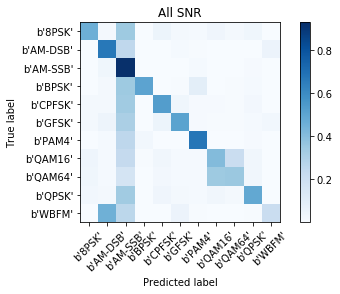

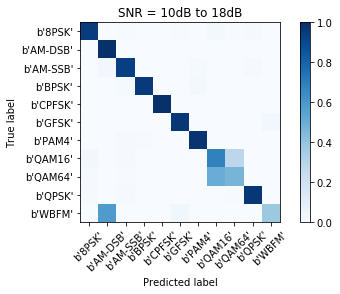

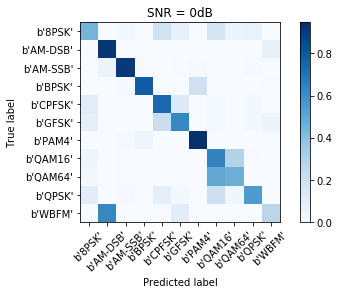

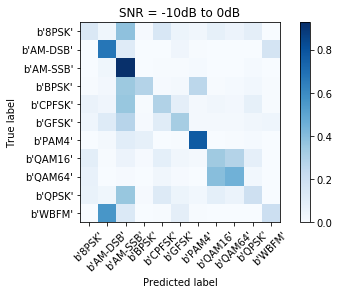

In [20]:
# Plot confusion matrix for all data
plt.figure()
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes, title='All SNR')


# Plot confusion matrix for 18dB SNR
plt.figure()
X_test_extracted = np.vstack((X_test[np.where(y_test_snr==np.bytes_('10'))], X_test[np.where(y_test_snr==np.bytes_('12'))], X_test[np.where(y_test_snr==np.bytes_('14'))], X_test[np.where(y_test_snr==np.bytes_('16'))], X_test[np.where(y_test_snr==np.bytes_('18'))]))
y_test_extracted = np.vstack((y_test[np.where(y_test_snr==np.bytes_('10'))], y_test[np.where(y_test_snr==np.bytes_('12'))], y_test[np.where(y_test_snr==np.bytes_('14'))], y_test[np.where(y_test_snr==np.bytes_('16'))], y_test[np.where(y_test_snr==np.bytes_('18'))]))

test_Y_hat = model.predict(X_test_extracted, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test_extracted.shape[0]):
    j = list(y_test_extracted[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes, title='SNR = 10dB to 18dB')


# Plot confusion matrix for 0dB SNR
plt.figure()
X_test_extracted = X_test[np.where(y_test_snr==np.bytes_('0'))]
y_test_extracted = y_test[np.where(y_test_snr==np.bytes_('0'))]

test_Y_hat = model.predict(X_test_extracted, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test_extracted.shape[0]):
    j = list(y_test_extracted[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes, title='SNR = 0dB')


# Plot confusion matrix for -10 to 0 dB SNR
plt.figure()
X_test_extracted = np.vstack((X_test[np.where(y_test_snr==np.bytes_('-10'))], X_test[np.where(y_test_snr==np.bytes_('-8'))], X_test[np.where(y_test_snr==np.bytes_('-6'))], X_test[np.where(y_test_snr==np.bytes_('-4'))], X_test[np.where(y_test_snr==np.bytes_('-2'))], X_test[np.where(y_test_snr==np.bytes_('0'))]))
y_test_extracted = np.vstack((y_test[np.where(y_test_snr==np.bytes_('-10'))], y_test[np.where(y_test_snr==np.bytes_('-8'))], y_test[np.where(y_test_snr==np.bytes_('-6'))], y_test[np.where(y_test_snr==np.bytes_('-4'))], y_test[np.where(y_test_snr==np.bytes_('-2'))], y_test[np.where(y_test_snr==np.bytes_('0'))]))

test_Y_hat = model.predict(X_test_extracted, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test_extracted.shape[0]):
    j = list(y_test_extracted[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes, title='SNR = -10dB to 0dB')

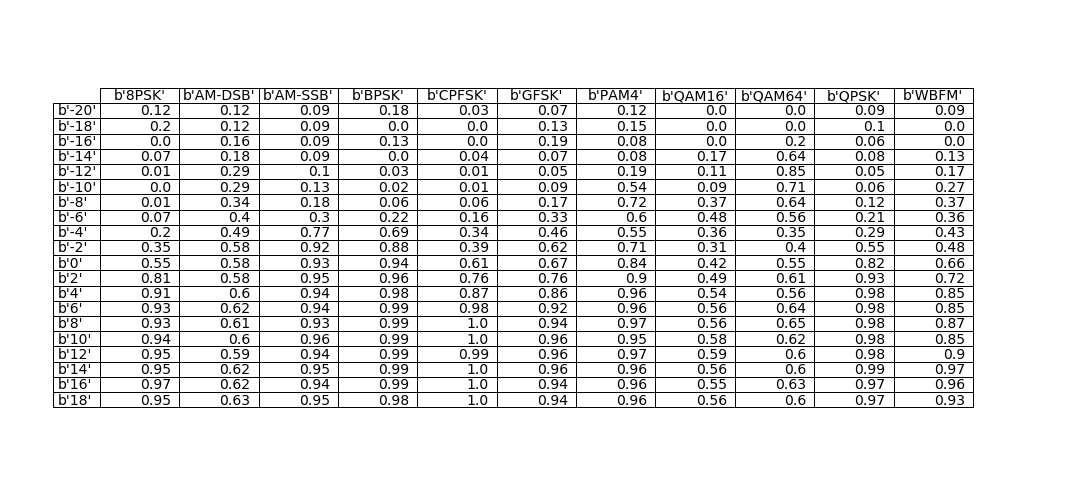

In [21]:
#Print Table of average error for each SNR and Label
fig = plt.figure(figsize = (15, 7))
ax = plt.subplot(111)
# fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
df = pd.DataFrame(acc_label_snr)
df = df.round(decimals = 2)
table = ax.table(cellText = df.values, rowLabels=snr_label_array, colLabels=classes, colWidths=[0.075 for x in classes], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
fig.tight_layout()
# print(df.to_latex(index=False))

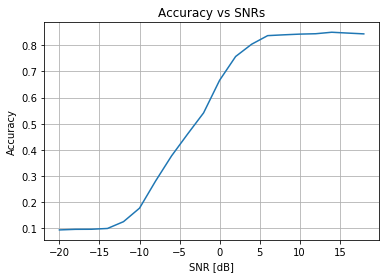

In [22]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.plot(np.arange(-20,20,2), acc_array)
plt.ylabel("Accuracy")
plt.xlabel('SNR [dB]')
plt.grid('on')